# Comprehensive Exploratory Data Analysis: Step by Step

In this notebook, we'll implement all the functions required to perform a thorough EDA. The analysis will help in understanding the data distribution, patterns, and categories that are crucial for predictive modeling.

**By the end, we'll be able to:**

- Understand the distribution of data
- Visualize categorical and continuous variables
- Detect and handle missing data
- Identify correlations and multicollinearity
- Conduct hypothesis testing (if necessary)
- Prepare data for machine learning modeling

## Table of Contents
- [1 - Packages](#1)
- [2 - Data Overview](#2)
    - [2.1 - Load the Data](#2-1)
    - [2.2 - Basic Information](#2-2)
- [3 - Univariate Analysis](#3)
    - [3.1 - Categorical Variables](#3-1)
    - [3.2 - Continuous Variables](#3-2)
- [4 - Handling Missing Data](#4)
    - [4.1 - Identifying Missing Data](#4-1)
    - [4.2 - Strategies for Handling Missing Data](#4-2)
- [5 - Bivariate Analysis](#5)
    - [5.1 - Correlation Analysis](#5-1)
    - [5.2 - Visualizing Relationships](#5-2)
        - [Exercise 6 - plot_relationships](#ex-6)
- [6 - Outlier Detection](#6)
    - [6.1 - Identifying Outliers](#6-1)
    - [6.2 - Handling Outliers](#6-2)
- [7 - Feature Engineering](#7)
    - [7.1 - Creating New Features](#7-1)
    - [7.2 - Transforming Features](#7-2)
- [8 - Preparing Data for Modeling](#8)
    - [8.1 - Data Encoding](#8-1)
    - [8.2 - Data Splitting](#8-2)

<a name='1'></a>
## 1 - Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

import os
# import wandb
import warnings

from config import *
from utils.eda_functions import *
from src.data_preprocessing.demographics import *
from src.data_preprocessing.vitals_labs import *
from utils.safe_display import blind_display

%load_ext autoreload
%autoreload 2

In [2]:
# Configuration & Settings:

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

warnings.filterwarnings('ignore')
os.environ['WANDB_SILENT'] = 'true'
sns.set_theme(style="whitegrid")

# # Login and initialize a new wandb run
# wandb_key = os.environ.get("WANDB_API_KEY")
# ! wandb login $wandb_key
#
# run = wandb.init(
#     project='FuzzyMedNet',
#     name='patient_eda',
#     job_type='eda'
# )

In [3]:
# Safety flag - when set to True will not display sensitive data
BLINDED = False

<a name='2'></a>
## 2 - Data Overview

In this section, we will load our dataset and take a look at some basic information.

<a name='2-1'></a>
### 2.1 - Load the Data

In [4]:
# Open the file in read mode
with h5py.File(DATA_FILE_PATH, 'r') as file:
    # Print the keys at the root of the file
    print(list(file.keys()))

patients = pd.read_hdf(DATA_FILE_PATH, 'patients')
vitals_labs = pd.read_hdf(DATA_FILE_PATH, 'vitals_labs')
vitals_labs_mean = pd.read_hdf(DATA_FILE_PATH, 'vitals_labs_mean')
interventions = pd.read_hdf(DATA_FILE_PATH, 'interventions')
codes = pd.read_hdf(DATA_FILE_PATH, 'codes')

['codes', 'interventions', 'patients', 'vitals_labs', 'vitals_labs_mean']


<a name='2-2'></a>
### 2.2 - Basic Information

In [5]:
print(f'patients.shape: {patients.shape}')
print(patients.info())

patients.shape: (34472, 28)
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 34472 entries, (3, 145834, 211552) to (99999, 113369, 246512)
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   gender                  34472 non-null  category      
 1   ethnicity               34472 non-null  category      
 2   age                     34472 non-null  float64       
 3   insurance               34472 non-null  object        
 4   admittime               34472 non-null  datetime64[ns]
 5   diagnosis_at_admission  34471 non-null  object        
 6   dischtime               34472 non-null  datetime64[ns]
 7   discharge_location      34472 non-null  object        
 8   fullcode_first          28162 non-null  float64       
 9   dnr_first               28162 non-null  float64       
 10  fullcode                28162 non-null  float64       
 11  dnr                     28162 non-null  fl

In [6]:
print(f'vitals_labs_mean.shape: {vitals_labs_mean.shape}')
print(vitals_labs_mean.info())

vitals_labs_mean.shape: (2200954, 104)
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2200954 entries, (3, 145834, 211552, 0) to (99999, 113369, 246512, 26)
Columns: 104 entries, ('alanine aminotransferase', 'mean') to ('ph urine', 'mean')
dtypes: float64(104)
memory usage: 1.7 GB
None


In [7]:
print(f'interventions.shape: {interventions.shape}')
print(interventions.info())

interventions.shape: (2200954, 14)
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2200954 entries, (3, 145834, 211552, 0) to (99999, 113369, 246512, 26)
Data columns (total 14 columns):
 #   Column             Dtype
---  ------             -----
 0   vent               int64
 1   vaso               int64
 2   adenosine          int64
 3   dobutamine         int64
 4   dopamine           int64
 5   epinephrine        int64
 6   isuprel            int64
 7   milrinone          int64
 8   norepinephrine     int64
 9   phenylephrine      int64
 10  vasopressin        int64
 11  colloid_bolus      int64
 12  crystalloid_bolus  int64
 13  nivdurations       int64
dtypes: int64(14)
memory usage: 269.0 MB
None


In [8]:
blind_display(patients, vitals_labs_mean, interventions, codes, blinded=BLINDED)

patients.shape:  (34472, 28)


,,,gender,ethnicity,age,insurance,admittime,diagnosis_at_admission,dischtime,discharge_location,fullcode_first,dnr_first,...,outtime,los_icu,admission_type,first_careunit,mort_icu,mort_hosp,hospital_expire_flag,hospstay_seq,readmission_30,max_hours
subject_id,hadm_id,icustay_id,,,,,,,,,,,,,,,,,,,,,
3,145834,211552,M,WHITE,76.526792,Medicare,2101-10-20 19:08:00,HYPOTENSION,2101-10-31 13:58:00,SNF,1.0,0.0,...,2101-10-26 20:43:09,6.064560,EMERGENCY,MICU,0,0,0,1,0,145
4,185777,294638,F,WHITE,47.845047,Private,2191-03-16 00:28:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",2191-03-23 18:41:00,HOME WITH HOME IV PROVIDR,1.0,0.0,...,2191-03-17 16:46:31,1.678472,EMERGENCY,MICU,0,0,0,1,0,40
6,107064,228232,F,WHITE,65.942297,Medicare,2175-05-30 07:15:00,CHRONIC RENAL FAILURE/SDA,2175-06-15 16:00:00,HOME HEALTH CARE,1.0,0.0,...,2175-06-03 13:39:54,3.672917,ELECTIVE,SICU,0,0,0,1,0,88
9,150750,220597,M,UNKNOWN/NOT SPECIFIED,41.790228,Medicaid,2149-11-09 13:06:00,HEMORRHAGIC CVA,2149-11-14 10:15:00,DEAD/EXPIRED,1.0,0.0,...,2149-11-14 20:52:14,5.323056,EMERGENCY,MICU,1,1,1,1,0,127
11,194540,229441,F,WHITE,50.148295,Private,2178-04-16 06:18:00,BRAIN MASS,2178-05-11 19:00:00,HOME HEALTH CARE,1.0,0.0,...,2178-04-17 20:21:05,1.584410,EMERGENCY,SICU,0,0,0,1,0,38


vitals_labs_mean.shape:  (2200954, 104)


LEVEL2                                 alanine aminotransferase albumin  \
Aggregation Function                                       mean    mean   
subject_id hadm_id icustay_id hours_in                                    
3          145834  211552     0                            25.0     1.8   
                              1                             NaN     NaN   
                              2                             NaN     NaN   
                              3                             NaN     NaN   
                              4                             NaN     NaN   

LEVEL2                                 albumin ascites albumin pleural  \
Aggregation Function                              mean            mean   
subject_id hadm_id icustay_id hours_in                                   
3          145834  211552     0                    NaN             NaN   
                              1                    NaN             NaN   
                              2                    NaN             NaN   
                              3                    NaN             NaN   
                              4                    NaN             NaN   

LEVEL2                                 albumin urine alkaline phosphate  \
Aggregation Function                            mean               mean   
subject_id hadm_id icustay_id hours_in                                    
3          145834  211552     0                  NaN               73.0   
                              1                  NaN                NaN   
                              2                  NaN                NaN   
                              3                  NaN                NaN   
                              4                  NaN                NaN   

LEVEL2                                  anion gap asparate aminotransferase  \
Aggregation Function                         mean                      mean   
subject_id hadm_id icustay_id hours_in                                        
3          145834  211552     0         20.666667                      69.0   
                              1               NaN                       NaN   
                              2               NaN                       NaN   
                              3               NaN                       NaN   
                              4               NaN                       NaN   

LEVEL2                                 basophils bicarbonate  ...  \
Aggregation Function                        mean        mean  ...   
subject_id hadm_id icustay_id hours_in                        ...   
3          145834  211552     0              NaN   16.333333  ...   
                              1              NaN         NaN  ...   
                              2              NaN         NaN  ...   
                              3              NaN         NaN  ...   
                              4              NaN         NaN  ...   

LEVEL2                                 total protein total protein urine  \
Aggregation Function                            mean                mean   
subject_id hadm_id icustay_id hours_in                                     
3          145834  211552     0                  NaN                 NaN   
                              1                  NaN                 NaN   
                              2                  NaN                 NaN   
                              3                  NaN                 NaN   
                              4                  NaN                 NaN   

LEVEL2                                 troponin-i troponin-t venous pvo2  \
Aggregation Function                         mean       mean        mean   
subject_id hadm_id icustay_id hours_in                                     
3          145834  211552     0               NaN        NaN         NaN   
                              1               NaN        NaN         NaN   
                              

interventions.shape:  (2200954, 14)


vent  vaso  adenosine  dobutamine  \
subject_id hadm_id icustay_id hours_in                                      
3          145834  211552     0            1     0          0           0   
                              1            1     1          0           0   
                              2            1     1          0           0   
                              3            1     1          0           0   
                              4            1     1          0           0   

                                        dopamine  epinephrine  isuprel  \
subject_id hadm_id icustay_id hours_in                                   
3          145834  211552     0                0            0        0   
                              1                1            0        0   
                              2                1            0        0   
                              3                0            0        0   
                              4                0            0        0   

                                        milrinone  norepinephrine  \
subject_id hadm_id icustay_id hours_in                              
3          145834  211552     0                 0               0   
                              1                 0               0   
                              2                 0               0   
                              3                 0               0   
                              4                 0               1   

                                        phenylephrine  vasopressin  \
subject_id hadm_id icustay_id hours_in                               
3          145834  211552     0                     0            0   
                              1                     1            0   
                              2                     1            0   
                              3                     1            0   
                              4                     1            0   

                                        colloid_bolus  crystalloid_bolus  \
subject_id hadm_id icustay_id hours_in                                     
3          145834  211552     0                     0                  0   
                              1                     0                  0   
                              2                     0                  0   
                              3                     0                  0   
                              4                     0                  0   

                                        nivdurations  
subject_id hadm_id icustay_id hours_in                
3          145834  211552     0                    0  
                              1                    0  
                              2                    0  
                              3                    0  
                              4                    0

codes.shape:  (2200954, 1)


icd9_codes
subject_id hadm_id icustay_id hours_in                                                   
3          145834  211552     0         [0389, 78559, 5849, 4275, 41071, 4280, 6826, 4...
                              1         [0389, 78559, 5849, 4275, 41071, 4280, 6826, 4...
                              2         [0389, 78559, 5849, 4275, 41071, 4280, 6826, 4...
                              3         [0389, 78559, 5849, 4275, 41071, 4280, 6826, 4...
                              4         [0389, 78559, 5849, 4275, 41071, 4280, 6826, 4...

<a name='3'></a>
## 3 - Univariate Analysis

<a name='3-1'></a>
### 3.1 - Categorical Variables

`patients` DataFrame

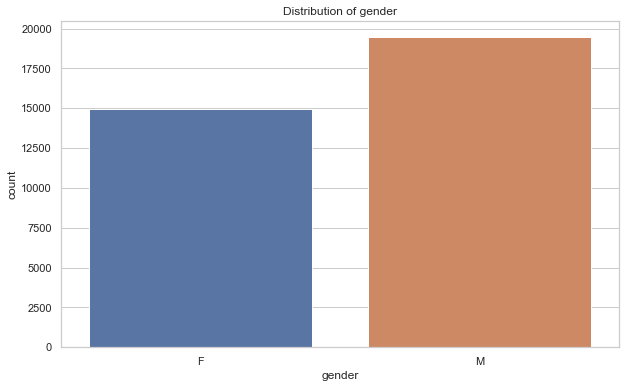

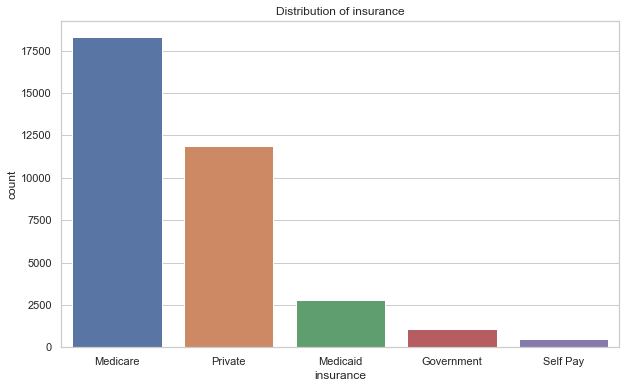

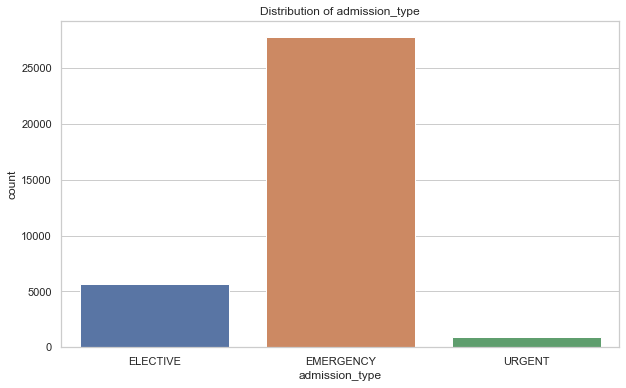

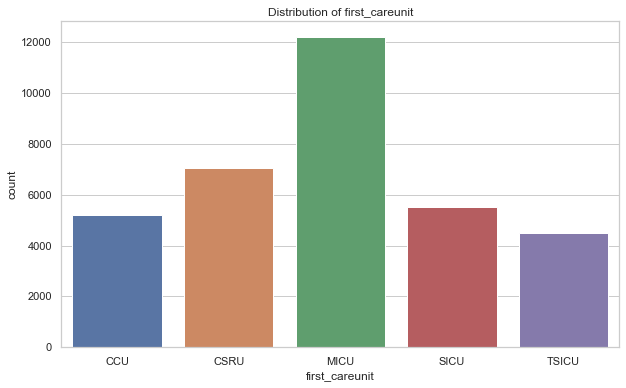

In [9]:
patient_categorical_vars = ["gender", "insurance", "admission_type", "first_careunit"]
plot_categorical_columns(patients, patient_categorical_vars)

In [10]:
# check ethnicity categories
patients['ethnicity'].value_counts(dropna=False)

WHITE                                                       24429
UNKNOWN/NOT SPECIFIED                                        3221
BLACK/AFRICAN AMERICAN                                       2456
HISPANIC OR LATINO                                            881
OTHER                                                         785
UNABLE TO OBTAIN                                              652
ASIAN                                                         545
PATIENT DECLINED TO ANSWER                                    351
ASIAN - CHINESE                                               166
HISPANIC/LATINO - PUERTO RICAN                                124
BLACK/CAPE VERDEAN                                            122
WHITE - RUSSIAN                                                99
MULTI RACE ETHNICITY                                           77
BLACK/HAITIAN                                                  64
WHITE - OTHER EUROPEAN                                         59
HISPANIC/L

In [11]:
# Regroup similar categories of ethnicities
patients['ethnicity'] = patients['ethnicity'].apply(categorize_ethnicity)
patients['ethnicity'].value_counts(dropna=False)

WHITE              24675
OTHER/UNKNOWN       5086
BLACK               2667
HISPANIC            1137
ASIAN                865
ISLANDER              25
NATIVE AMERICAN       17
Name: ethnicity, dtype: int64

In [12]:
# regroup admission types into: EMERGENCY & ELECTIVE
patients['admission_type'] = patients['admission_type'].apply(group_admission_type)
patients['admission_type'].value_counts(dropna=False)

EMERGENCY    28767
ELECTIVE      5705
Name: admission_type, dtype: int64

<a name='3-2'></a>
### 3.2 - Continuous Variables

`patients` DataFrame

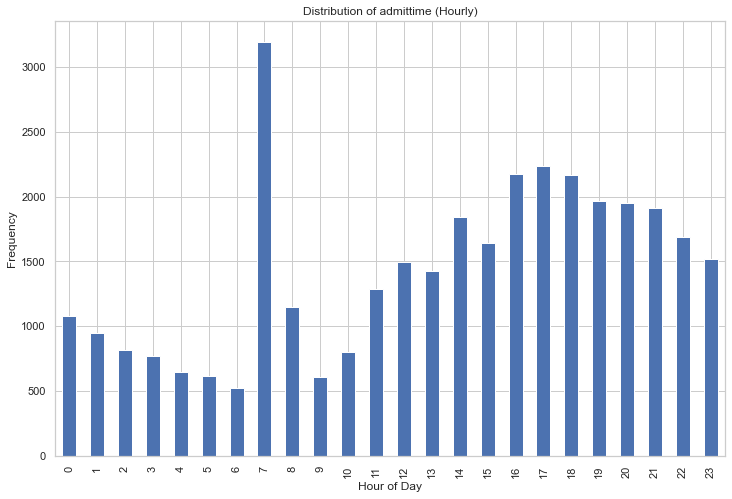

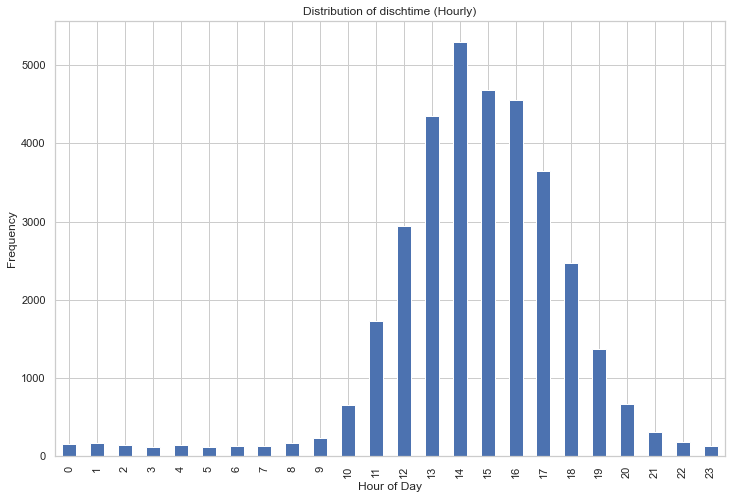

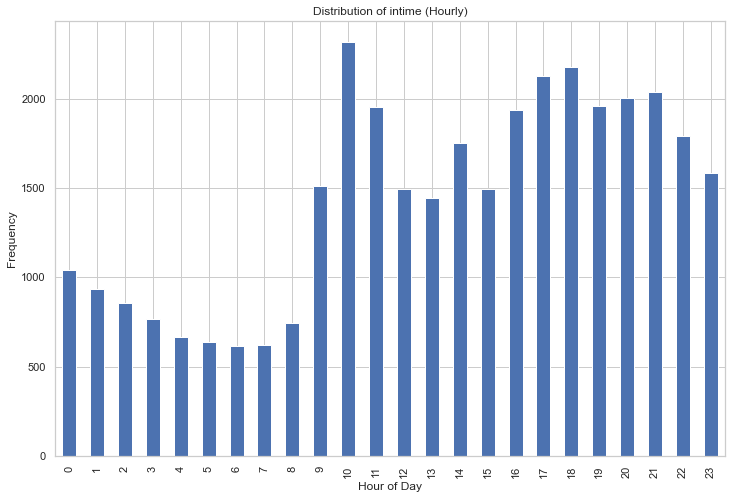

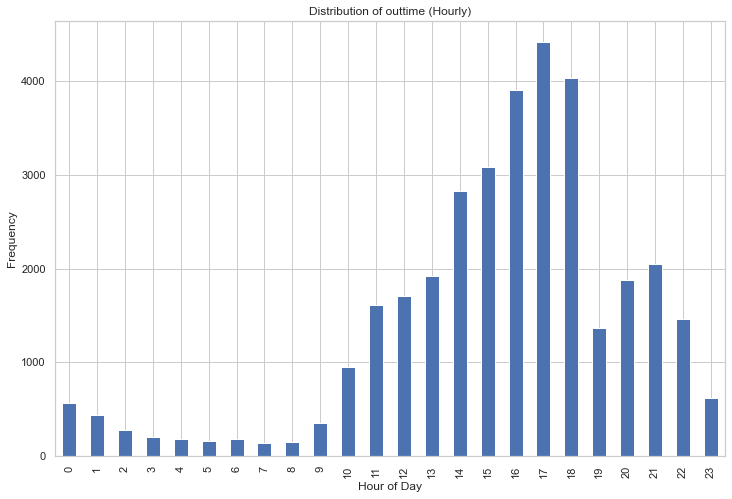

In [13]:
# Calculate length of stay in ICU
patients['icu_stay_length'] = calculate_duration(patients, 'intime', 'outtime', 'h')  # in hours

# Plot distribution of times
time_columns = ['admittime', 'dischtime', 'intime', 'outtime']
plot_time_analysis(patients, time_columns)

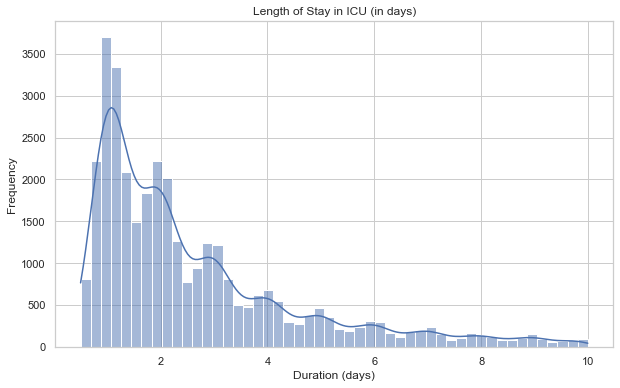

In [14]:
# Plot distribution of length of stay in ICU
plt.figure(figsize=(10,6))
sns.histplot(data=patients, x='los_icu', bins=50, kde=True)
plt.title('Length of Stay in ICU (in days)')
plt.xlabel('Duration (days)')
plt.ylabel('Frequency')
plt.show()

`vitals_labs_mean` DataFrame
1. **Descriptive Statistics**
We'll start by calculating summary statistics for the DataFrame. This will help us understand the central tendency, spread, and shape of the distribution of the dataset.
<br></br>
2. **Time-Series Plots**
For selected vital signs and lab measurements, we'll plot time-series graphs.
<br></br>
3. **Distribution Plots**
We'll visualize the distribution of selected columns to understand their shape, center, and spread.

In [15]:
vitals_labs_mean.describe()

LEVEL2,alanine aminotransferase,albumin,albumin ascites,albumin pleural,albumin urine,alkaline phosphate,anion gap,asparate aminotransferase,basophils,bicarbonate,...,total protein,total protein urine,troponin-i,troponin-t,venous pvo2,weight,white blood cell count,white blood cell count urine,ph,ph urine
Aggregation Function,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,...,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
count,43419.000000,28660.000000,114.000000,146.000000,131.000000,42244.000000,183732.000000,43439.000000,18593.000000,192632.000000,...,423.000000,872.000000,2027.000000,28427.000000,956.000000,61858.000000,178844.000000,5574.000000,201128.000000,23458.000000
mean,282.336995,3.079365,1.707018,1.713699,46.022137,122.315145,13.719931,348.145131,0.394192,24.234930,...,5.660993,139.375000,7.557382,0.850707,43.877092,83.073052,11.935059,23.313132,7.381335,5.809969
std,916.366506,0.684541,0.809755,0.573511,93.149753,143.607810,3.990472,1239.590637,0.487494,4.743463,...,1.091161,307.540901,10.657161,2.151251,14.872488,23.357670,10.007226,72.205027,0.078646,0.945936
min,2.000000,1.000000,0.200000,0.300000,0.400000,20.000000,5.000000,6.000000,0.100000,0.000000,...,3.300000,6.000000,0.010000,0.010000,0.000000,0.000000,0.000000,0.100000,6.500000,1.000000
25%,20.000000,2.600000,1.125000,1.225000,3.450000,61.000000,11.000000,27.000000,0.200000,22.000000,...,5.000000,22.000000,0.800000,0.030000,34.000000,67.267748,7.800000,2.000000,7.340000,5.000000
50%,39.000000,3.100000,1.500000,1.700000,9.800000,84.000000,13.000000,52.500000,0.300000,24.000000,...,5.600000,52.000000,2.600000,0.110000,41.000000,80.099998,10.600000,5.000000,7.390000,5.500000
75%,114.000000,3.600000,2.200000,2.100000,39.450000,129.000000,15.000000,143.666667,0.500000,27.000000,...,6.200000,121.000000,9.880000,0.530000,50.000000,95.473395,14.200000,14.000000,7.430000,6.500000
max,10000.000000,6.000000,5.000000,3.400000,589.000000,3625.000000,50.000000,20000.000000,40.000000,53.000000,...,13.200000,3790.000000,49.600000,20.850000,100.000000,250.000000,939.000000,929.000000,8.400000,10.000000


**Mean and Standard Deviation**
Alanine Aminotransferase: The mean value is 282.34, but the standard deviation is very high (916.37), indicating a wide spread of values.
Albumin: Has a mean of 3.08 and a standard deviation of 0.68, showing that the data points are relatively closely packed around the mean.
Anion Gap: Mean is around 13.72 with a standard deviation of 3.99.

**Min, Max, and Outliers**
Alanine Aminotransferase: The max value is 10000, which seems excessively high and could potentially be an outlier.
White Blood Cell Count: The max value is 939, which is much higher than the 75th percentile (14.2), indicating potential outliers.

**Missing Data**
Albumin Ascites: Count is only 114, suggesting a large number of missing values.
Albumin Pleural: Also has a low count of 146, indicating many missing values.

**Quartiles (25%, 50%, 75%)**
pH: The interquartile range (IQR) is very small (7.43 - 7.34 = 0.09), indicating that the majority of the pH values are close to each other.
Weight: The 25th percentile is 67.27 and the 75th percentile is 95.47, suggesting that most patients' weight falls within this range.

In [16]:
vitals_mean = pd.DataFrame(vitals_labs.mean(),columns=['mean'])
vitals_std = pd.DataFrame(vitals_labs.std(),columns=['stdev'])
vitals_missing = pd.DataFrame(vitals_labs.isnull().sum()/vitals_labs.shape[0]*100,columns=['missing percent'])

vitals_summary = pd.concat([vitals_mean,vitals_std,vitals_missing],axis=1)
vitals_summary.index = vitals_summary.index.droplevel(1)
vitals_summary.sort_values(by='missing percent', ascending=True, inplace=True)
vitals_summary.to_json('../resources/vitals_summary.json', lines=True)

,mean,stdev,missing percent
LEVEL2,,,
lymphocytes pleural,NaN,NaN,100.0
creatinine pleural,NaN,NaN,100.0
red blood cell count pleural,NaN,NaN,100.0
lymphocytes ascites,NaN,NaN,100.0
lactate dehydrogenase pleural,NaN,NaN,100.0
...,...,...,...
lymphocytes percent,0.000064,0.008004,0.0
magnesium,0.154377,0.577340,0.0
mean blood pressure,1.132178,1.433561,0.0


In [22]:
vitals_summary.sort_values(by='missing percent', ascending=True, inplace=True)
vitals_summary.to_json('../resources/vitals_summary.json', orient='records', lines=True)

In [17]:
# Filter data to a 30-hour period
vitals_labs_filtered = vitals_labs_mean[vitals_labs_mean.index.get_level_values('hours_in') <= 30]

# Flatten the multi-level column names
vitals_labs_flatten = vitals_labs_filtered.copy()
vitals_labs_flatten.columns = [col[0] for col in vitals_labs_filtered.columns.values]
blind_display(vitals_labs_flatten, blinded=BLINDED)

vitals_labs_flatten.shape:  (995849, 104)


alanine aminotransferase  albumin  \
subject_id hadm_id icustay_id hours_in                                      
3          145834  211552     0                             25.0      1.8   
                              1                              NaN      NaN   
                              2                              NaN      NaN   
                              3                              NaN      NaN   
                              4                              NaN      NaN   

                                        albumin ascites  albumin pleural  \
subject_id hadm_id icustay_id hours_in                                     
3          145834  211552     0                     NaN              NaN   
                              1                     NaN              NaN   
                              2                     NaN              NaN   
                              3                     NaN              NaN   
                              4                     NaN              NaN   

                                        albumin urine  alkaline phosphate  \
subject_id hadm_id icustay_id hours_in                                      
3          145834  211552     0                   NaN                73.0   
                              1                   NaN                 NaN   
                              2                   NaN                 NaN   
                              3                   NaN                 NaN   
                              4                   NaN                 NaN   

                                        anion gap  asparate aminotransferase  \
subject_id hadm_id icustay_id hours_in                                         
3          145834  211552     0         20.666667                       69.0   
                              1               NaN                        NaN   
                              2               NaN                        NaN   
                              3               NaN                        NaN   
                              4               NaN                        NaN   

                                        basophils  bicarbonate  ...  \
subject_id hadm_id icustay_id hours_in                          ...   
3          145834  211552     0               NaN    16.333333  ...   
                              1               NaN          NaN  ...   
                              2               NaN          NaN  ...   
                              3               NaN          NaN  ...   
                              4               NaN          NaN  ...   

                                        total protein  total protein urine  \
subject_id hadm_id icustay_id hours_in                                       
3          145834  211552     0                   NaN                  NaN   
                              1                   NaN                  NaN   
                              2                   NaN                  NaN   
                              3                   NaN                  NaN   
                              4                   NaN                  NaN   

                                        troponin-i  troponin-t  venous pvo2  \
subject_id hadm_id icustay_id hours_in                                        
3          145834  211552     0                NaN         NaN          NaN   
                              1                NaN         NaN          NaN   
                              2                NaN         NaN          NaN   
                              3                NaN         NaN          NaN   
                              4                NaN         NaN          NaN   

                                        weight  white blood cell count  \
subject_id hadm_id icustay_id hours_in                                   
3          145834  211552     0            NaN               14.842857   
                              1            Na

In [18]:
# Read the variable ranged csv file to extract 'Valid Low', and 'Valid High' values per measurement
variable_ranges_df = pd.read_csv('../resources/variable_ranges.csv')
variable_ranges_df['LEVEL2'] = variable_ranges_df['LEVEL2'].apply(lambda x: x.lower())
variable_ranges_df.head()

,LEVEL2,LEVEL1,OUTLIER LOW,VALID LOW,IMPUTE,VALID HIGH,OUTLIER HIGH
0,alanine aminotransferase,NaN,0.0,2.0,34.0,10000.0,11000.0
1,albumin,NaN,0.0,0.6,3.1,6.0,60.0
2,alkaline phosphate,NaN,0.0,20.0,106.0,3625.0,4000.0
3,anion gap,NaN,0.0,5.0,13.0,50.0,55.0
4,asparate aminotransferase,NaN,0.0,6.0,40.0,20000.0,22000.0


In [19]:
vitals_labs_desc = vitals_labs_flatten.describe()
len(vitals_labs_desc.columns)

104

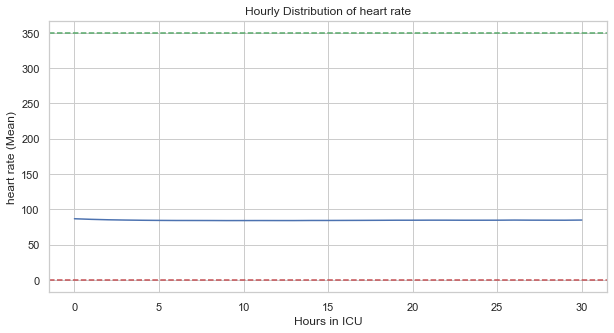

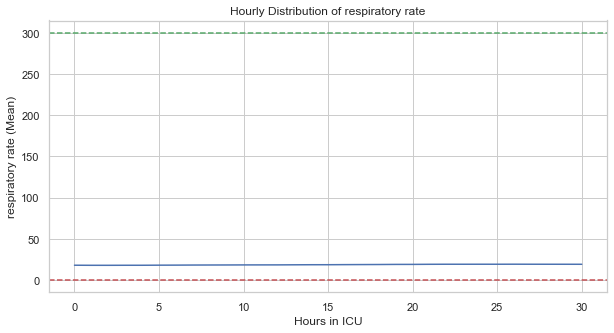

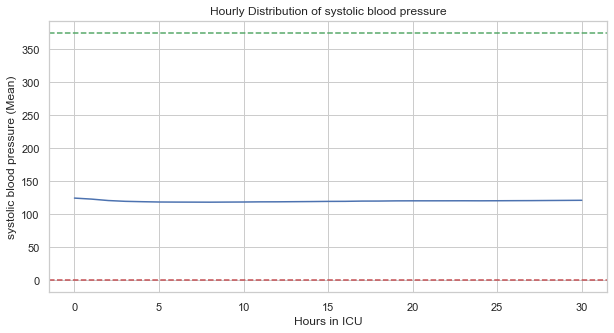

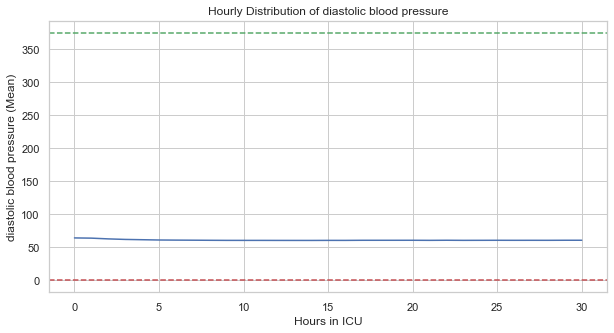

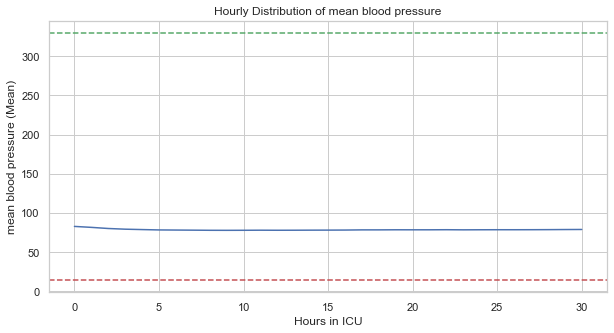

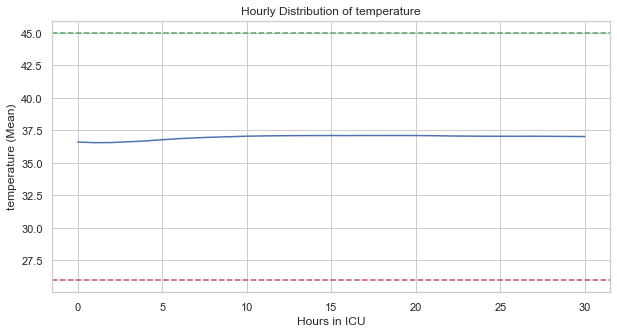

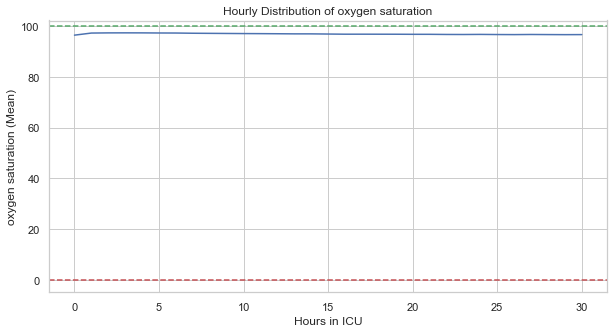

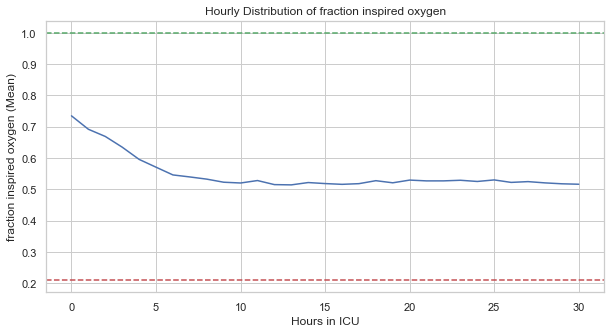

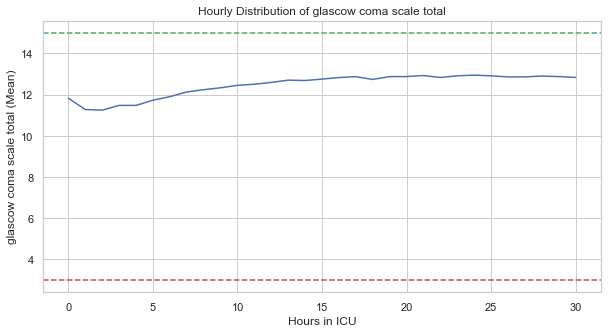

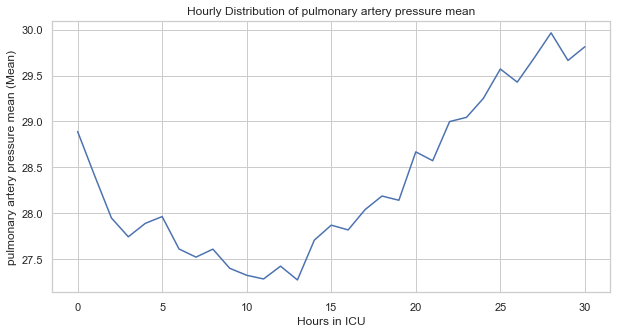

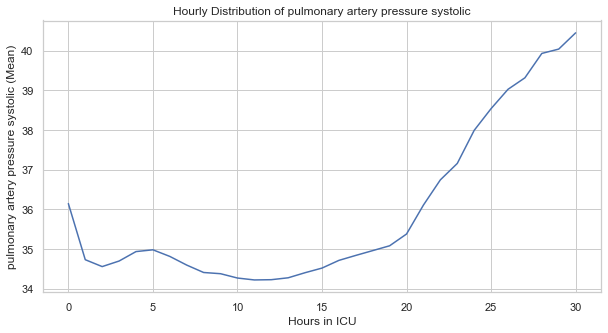

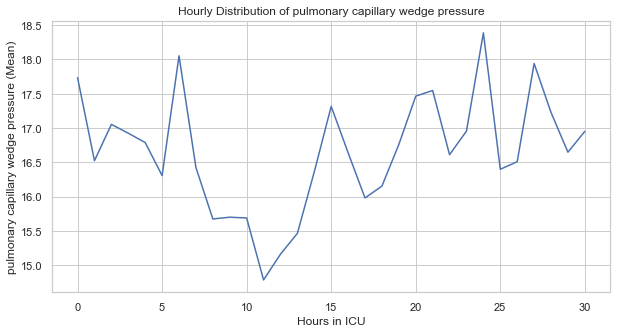

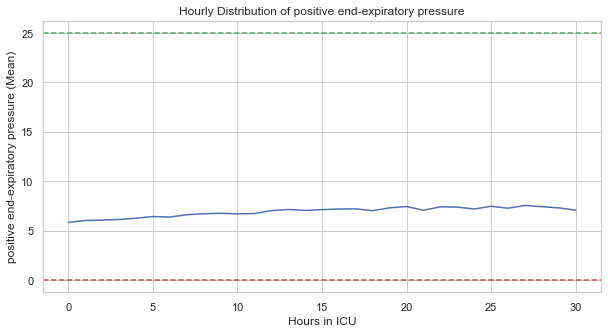

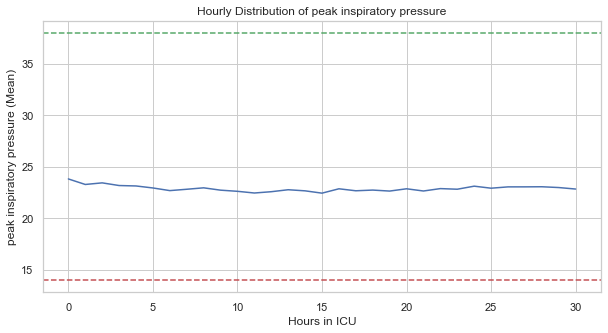

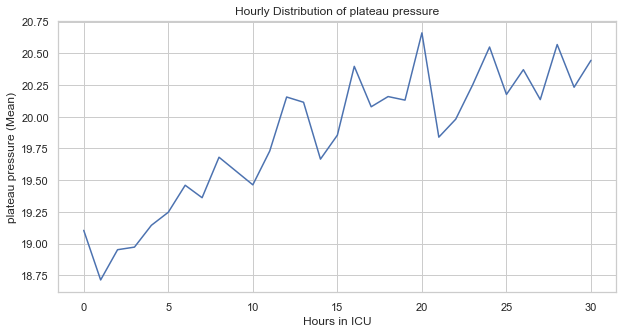

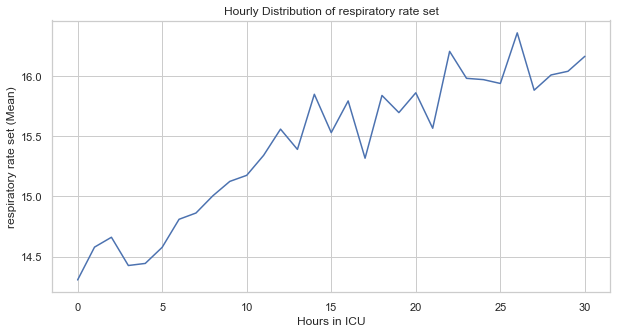

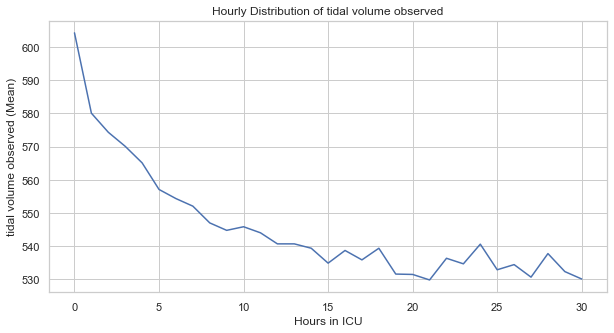

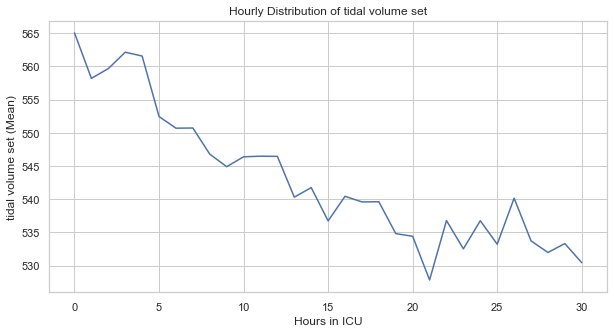

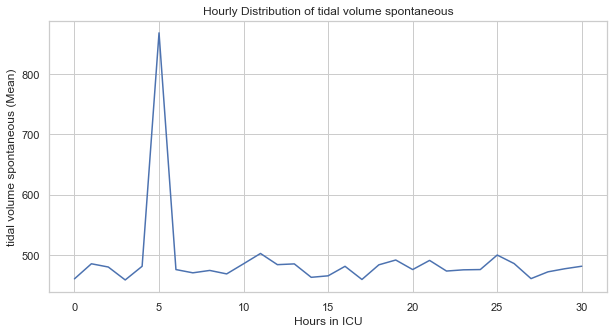

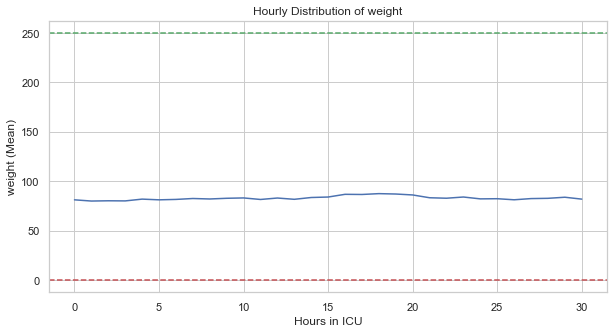

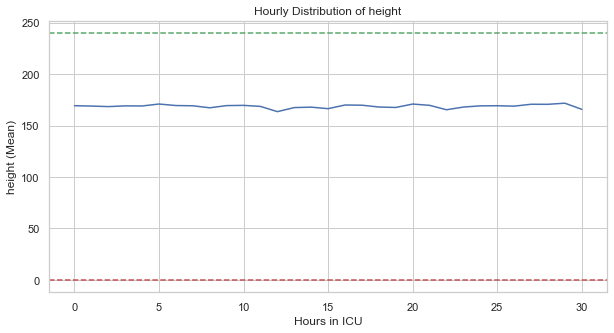

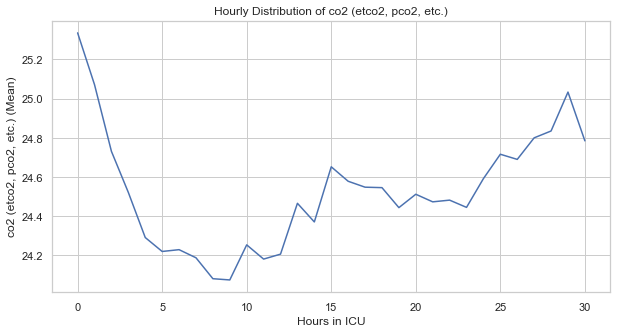

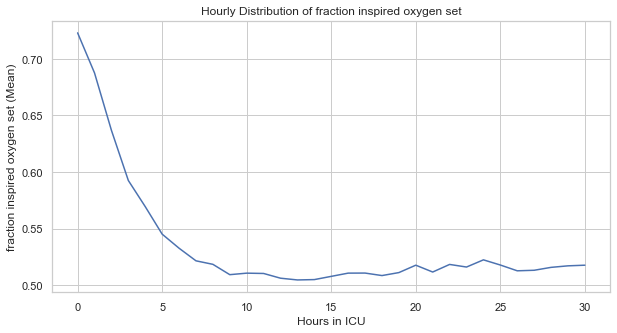

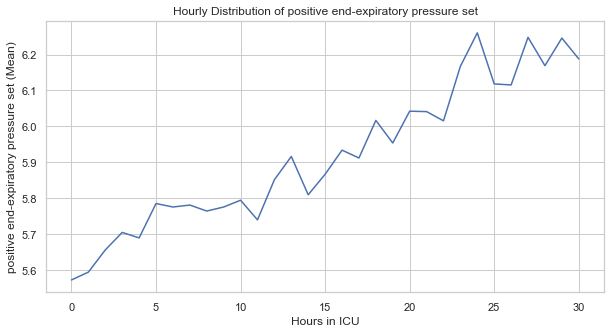

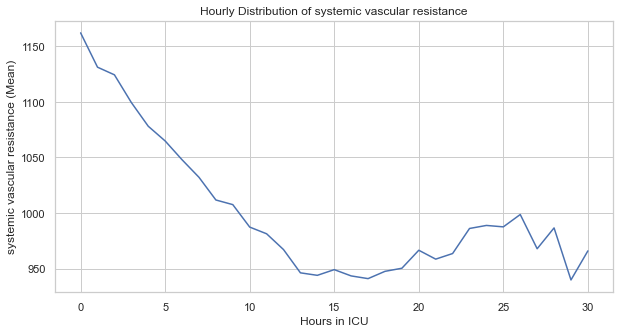

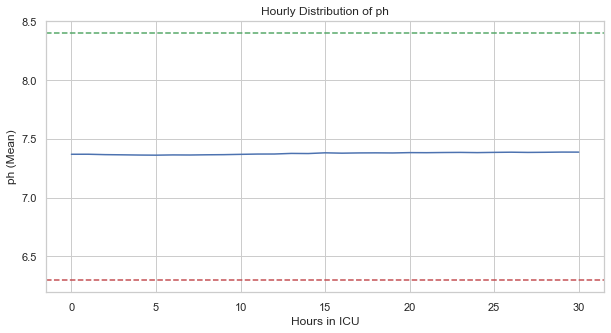

In [20]:
plot_hourly_distributions(df=vitals_labs_flatten, features=VITAL_SIGNS,valid_ranges=variable_ranges_df)

<a name='4'></a>
## 4 - Handling Missing Data

<a name='4-1'></a>
### 4.1 - Identifying Missing Data

<a name='4-2'></a>
### 4.2 - Strategies for Handling Missing Data

<a name='5'></a>
## 5 - Bivariate Analysis

<a name='5-1'></a>
### 5.1 - Correlation Analysis

<a name='5-2'></a>
### 5.2 - Visualizing Relationships

<a name='6'></a>
## 6 - Outlier Detection

<a name='6-1'></a>
### 6.1 - Identifying Outliers

<a name='6-2'></a>
### 6.2 - Handling Outliers

<a name='7'></a>
## 7 - Feature Engineering

<a name='7-1'></a>
### 7.1 - Creating New Features

<a name='7-2'></a>
### 7.2 - Transforming Features

<a name='8'></a>
## 8 - Preparing Data for Modeling

<a name='8-1'></a>
### 8.1 - Data Encoding

<a name='8-2'></a>
### 8.2 - Data Splitting